#  Multi-label Classification 1

## Importing required packages

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer, f1_score
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from random import shuffle

## Task 0: Load the Yeast Dataset

In [2]:
# Data Preprocessing Packages
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff

df = pd.read_csv('../data/yeast.csv')
#df.drop(columns = ['Unnamed: 0'],inplace = True)
df.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


In [3]:
X = df.iloc[:, 0:-14]

In [4]:
y = df.iloc[:,-14:]
y

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2413,1,1,0,0,0,0,0,0,0,0,0,1,1,0
2414,0,0,0,0,0,1,1,1,0,0,0,1,1,0
2415,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [5]:
labels =list(y.columns)

In [6]:
#labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

In [7]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = 0.7)

In [8]:
# Custom accuracy score based on hamming loss implementation

def get_accuracy_score(y_test,y_pred):
    
    if 'numpy' not in str(type(y_pred)):
        y_pred = y_pred.to_numpy()
        
    if 'numpy' not in str(type(y_test)):
        y_test = y_test.to_numpy()
    
    
    assert(y_test.shape == y_pred.shape)
    
    if y_pred.shape[1] <= 5: #For a smaller number of labels, a ratio of half the labels being correct is good enough
        ratio = 0.5
    else:
        ratio = 0.7 #For a number of labels, at least 70% of the predicted labels must be correct
    
    acc_rows = []
    
    for i in range(len(y_test)):
        acc_rows.append(np.count_nonzero(y_test[i]==y_pred[i]))
#         acc_rows.append(np.count_nonzero(y_test.iloc[i,:].values==y_pred.iloc[i,:].values)) #Count the number of matches
        
    acc_rows = [1 if x/y_pred.shape[1] >= ratio else 0 for x in acc_rows] #1 if ratio of match in a row is greater than ratio, else 0
    return sum(acc_rows)/len(acc_rows) # Mean accuracy


## Task 1: Implement the Binary Relevance Algorithm

In [9]:
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression()):
        self.base_model = base_model #base model - by default logistic regression
    
    def fit(self, X, y):
        self.model_list_ = []
        for column in y:  #For every label in y, fit the model independently
            clf = clone(self.base_model) #Clone the base model to avoid shallow copy
            A,b = check_X_y(X,y[column])
            clf.fit(A,b) #fit the model for the particular label value
            self.model_list_.append(clf) #Add the model to the saved model list
            
    def predict(self,X):
        check_is_fitted(self, ['model_list_']) 
        X = check_array(X)
        y_pred = pd.DataFrame() #Create a dataframe to save predictions
        i = 1
        for model in self.model_list_: #Make predictions for each label, using the corresponding mdodel
            y_pred_class = model.predict(X) 
            y_pred[i] = y_pred_class #Add current prediction to dataframe
            i+=1
        return y_pred.to_numpy() #return final predictions
    
    def predict_proba(self,X):
        check_is_fitted(self, ['model_list_']) #Check if model list is present
        X = check_array(X)
        y_pred = pd.DataFrame()
        i = 1
        for model in self.model_list_:
            y_pred_class = model.predict_proba(X) #Call predict_proba of the each base model
            y_pred[i] = [one_prob[1] for one_prob in y_pred_class] #Add the probability of 1 to the dataframe
            i+=1
        return y_pred.to_numpy() #return final probabilities

# 1.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 83.608815 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 16.528926 %
RandomForestClassifier F1 Score of  = 64.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.35      0.50       242
           1       0.66      0.38      0.48       329
           2       0.73      0.61      0.67       294
           3       0.79      0.42      0.55       261
           4       0.89      0.37      0.52       225
           5       0.88      0.13      0.22       181
           6       1.00      0.10      0.18       112
           7       0.67      0.07      0.12       120
           8       0.00      0.00      0.00        47
           9       1.00      0.02      0.04        87
          10     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


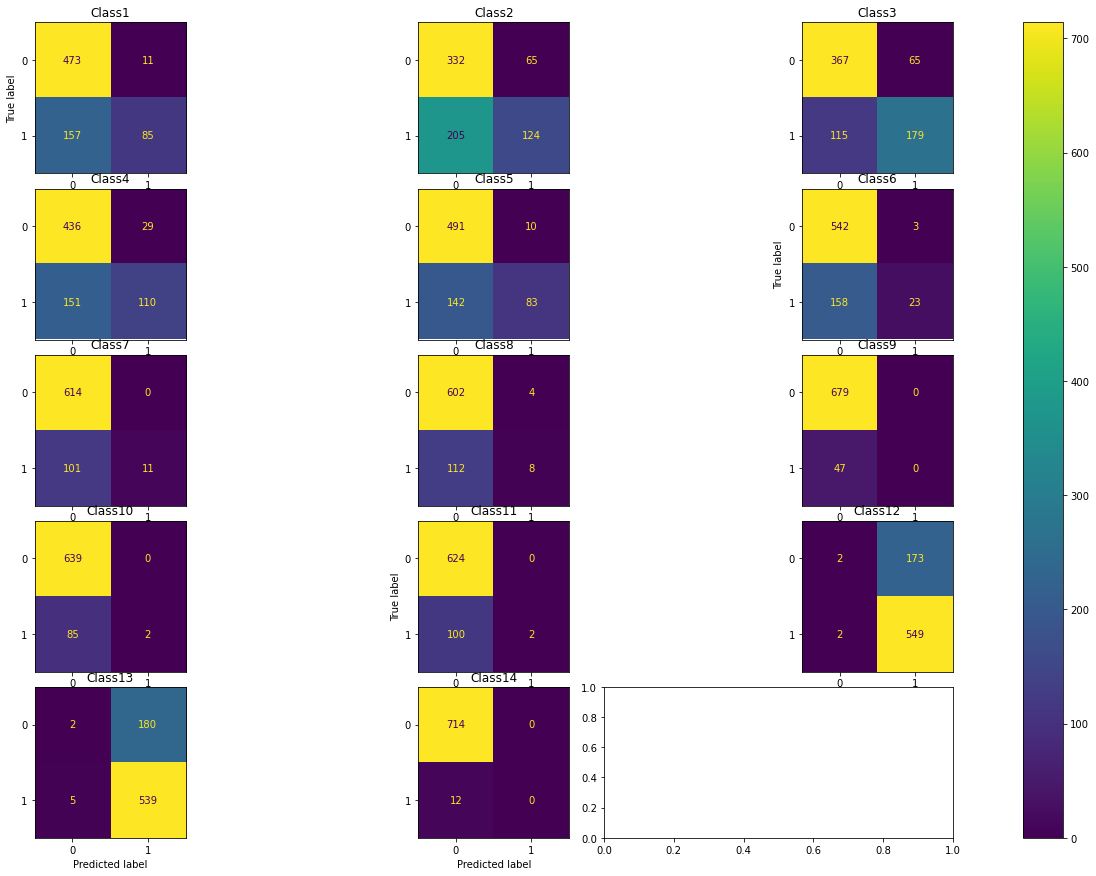

In [10]:
binclf = BinaryRelevanceClassifier(base_model=RandomForestClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 52.892562 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 10.192837 %
GaussianNB F1 Score of  = 55.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       242
           1       0.56      0.66      0.60       329
           2       0.61      0.72      0.66       294
           3       0.61      0.57      0.59       261
           4       0.56      0.56      0.56       225
           5       0.38      0.57      0.46       181
           6       0.27      0.63      0.38       112
           7       0.25      0.62      0.36       120
           8       0.07      0.28      0.11        47
           9       0.18      0.40      0.25        87
          10       0.20      0.32      0.25       102

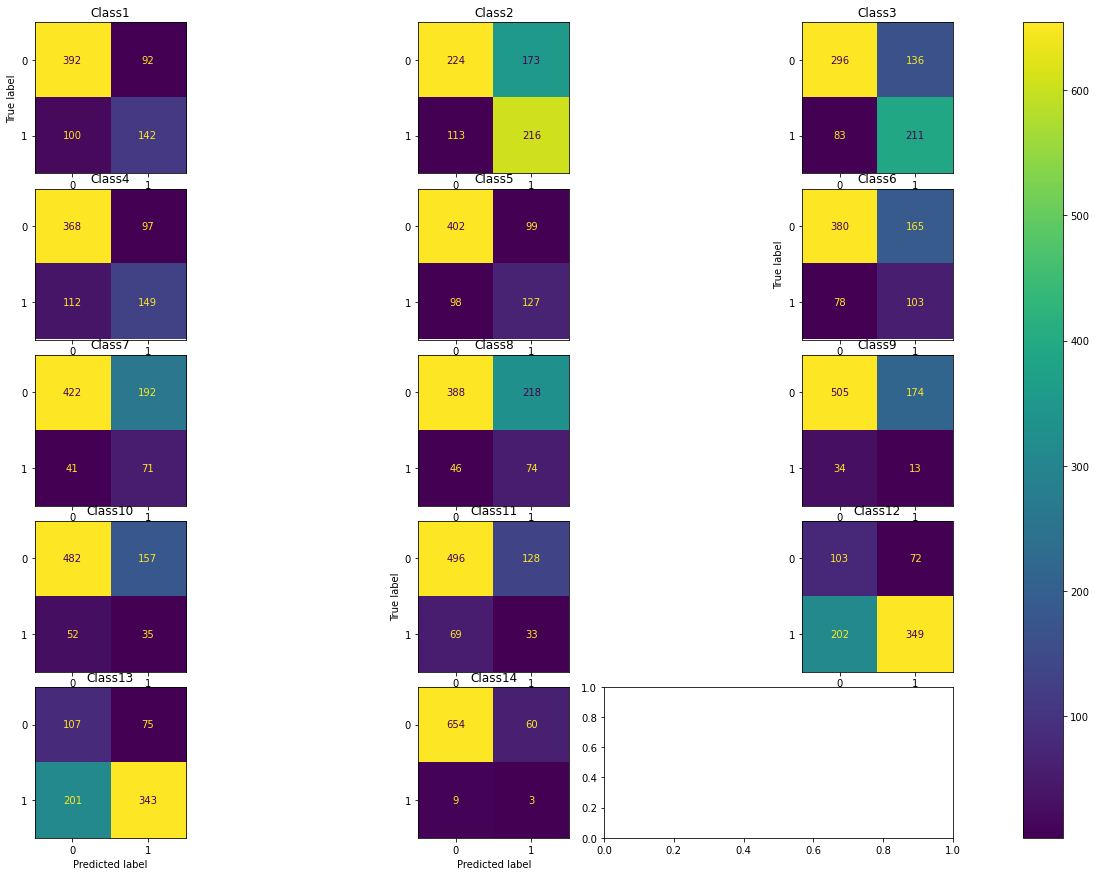

In [11]:
binclf = BinaryRelevanceClassifier(base_model=GaussianNB())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 61.707989 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 4.545455 %
DecisionTreeClassifier F1 Score of  = 55.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.50      0.52       242
           1       0.53      0.49      0.51       329
           2       0.58      0.58      0.58       294
           3       0.55      0.50      0.52       261
           4       0.47      0.49      0.48       225
           5       0.36      0.37      0.37       181
           6       0.27      0.35      0.30       112
           7       0.27      0.32      0.29       120
           8       0.02      0.02      0.02        47
           9       0.17      0.14      0.15        87
          10      

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


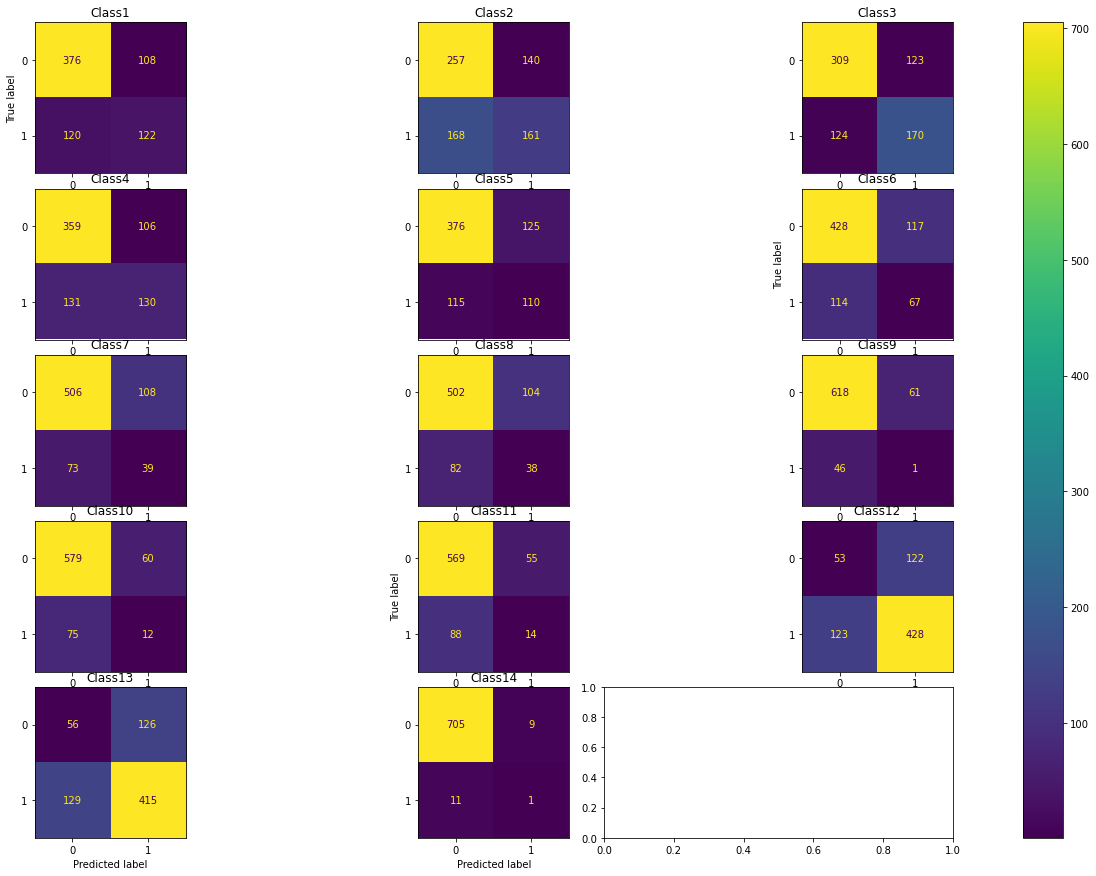

In [12]:
binclf = BinaryRelevanceClassifier(base_model=DecisionTreeClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.4 Support vector machine

 svm Accuracy (hamming loss) of  = 82.644628 %
--------------------------------------------------------------------------------------------------------------
svm Accuracy of  = 14.049587 %
svm F1 Score of  = 63.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.40      0.52       242
           1       0.60      0.45      0.51       329
           2       0.69      0.65      0.67       294
           3       0.68      0.54      0.60       261
           4       0.72      0.37      0.49       225
           5       0.00      0.00      0.00       181
           6       0.00      0.00      0.00       112
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00        47
           9       0.00      0.00      0.00        87
          10       0.00      0.00      0.00       102
          11       0

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


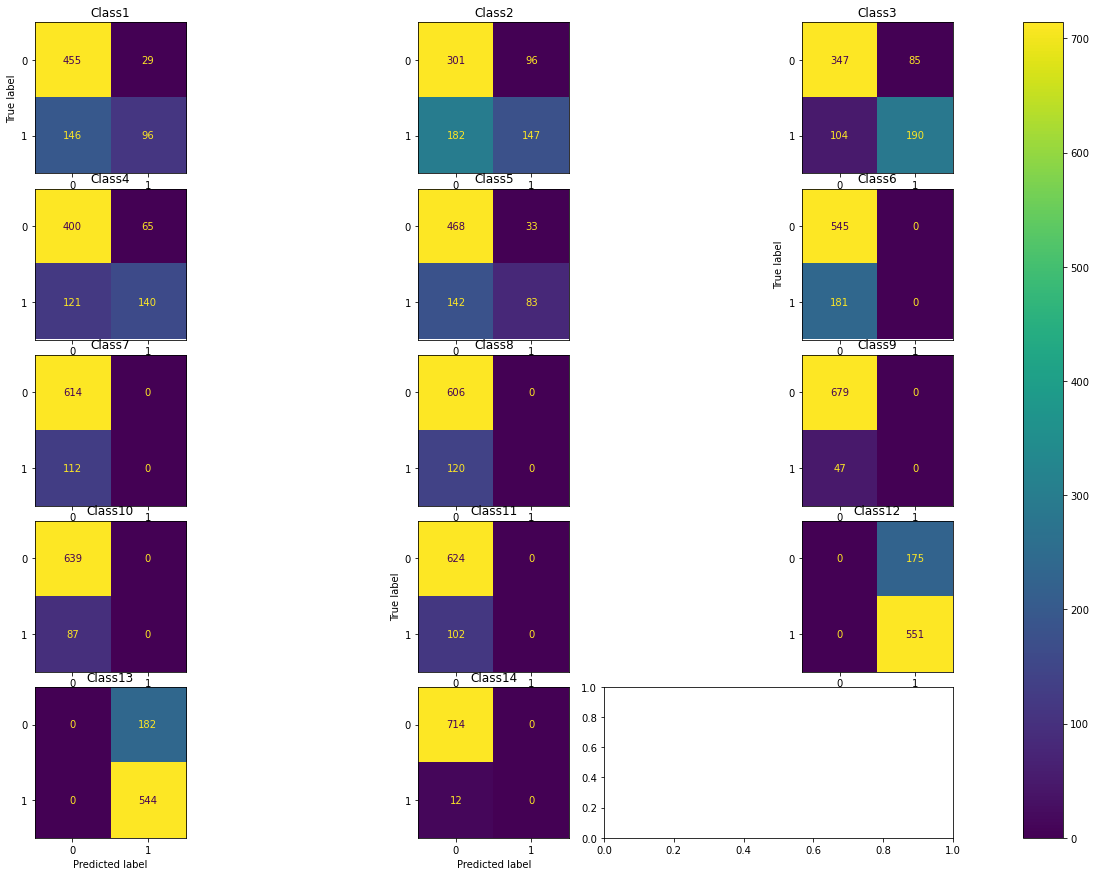

In [13]:
from sklearn import svm

binclf = BinaryRelevanceClassifier(base_model=svm.SVC(kernel='linear', C = 1.0))
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" svm Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("svm Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("svm F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 83.471074 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 14.876033 %
ExtraTreesClassifier F1 Score of  = 63.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.32      0.47       242
           1       0.68      0.40      0.50       329
           2       0.71      0.56      0.63       294
           3       0.84      0.38      0.52       261
           4       0.92      0.32      0.48       225
           5       0.90      0.10      0.18       181
           6       0.86      0.05      0.10       112
           7       0.60      0.03      0.05       120
           8       0.00      0.00      0.00        47
           9       1.00      0.02      0.04        87
          10       1.00

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


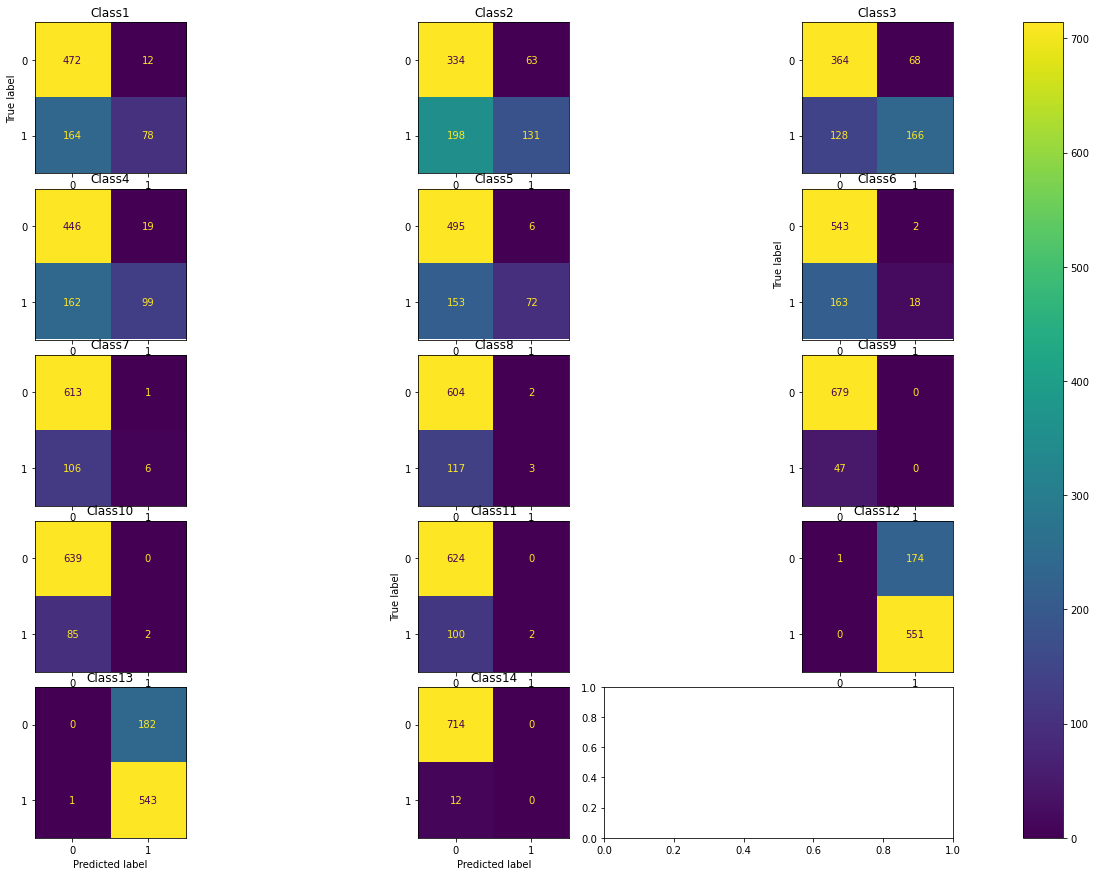

In [14]:
# 
binclf = BinaryRelevanceClassifier(base_model=ExtraTreesClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 1.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 76.033058 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 10.606061 %
AdaBoostClassifier F1 Score of  = 62.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.50      0.54       242
           1       0.61      0.53      0.57       329
           2       0.65      0.61      0.63       294
           3       0.64      0.53      0.58       261
           4       0.64      0.49      0.56       225
           5       0.51      0.38      0.43       181
           6       0.36      0.26      0.30       112
           7       0.33      0.22      0.26       120
           8       0.06      0.02      0.03        47
           9       0.34      0.11      0.17        87
          10       0.34      

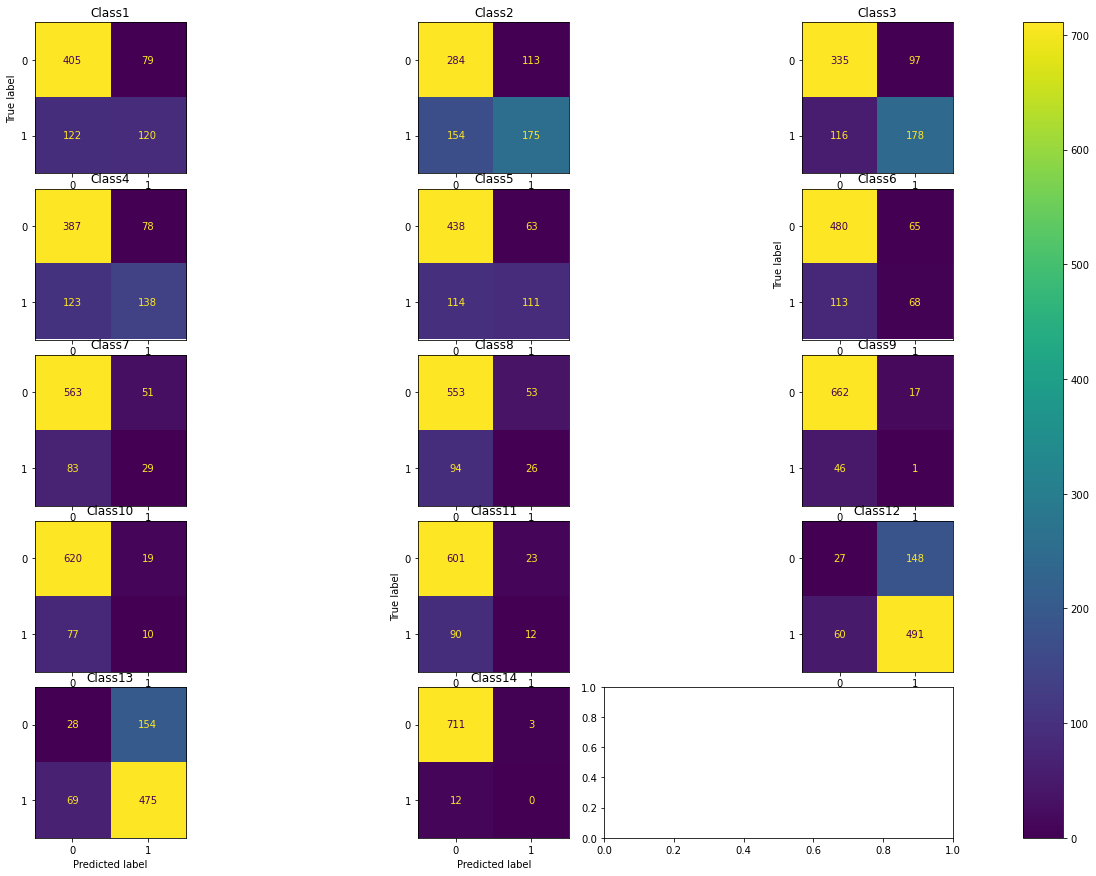

In [15]:

binclf = BinaryRelevanceClassifier(base_model=AdaBoostClassifier())
binclf.fit(X_train,y_train)
y_pred_BR = binclf.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_BR) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_BR)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_BR, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_BR))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_BR)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_BR)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

## Task 2: Implement the Classifier Chains Algorithm

In [16]:
class ClassifierChains(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model=LogisticRegression(), order = None, undersample=False):
        self.base_model = base_model # The base estimator
        self.order = order # Order of labels in which the labels are to be sent to the classifier
        self.undersample = undersample # Whether or not to undersample
        
    def fit(self, X, y):
        X_cpy = X.copy()
        y_cpy = y.copy()
        self.order_shuffle = None
        self.base_order = list(range(len(y.columns)))
        
        if self.order is None:
            self.order_shuffle = list(range(len(y_cpy.columns))) # Same order as input
            
        elif self.order == 'random':
            self.order_shuffle = list(range(len(y_cpy.columns))) # Random label order
            random.shuffle(self.order_shuffle)
            print(self.order_shuffle)
            
        else:
            if len(self.order) == len(y.columns) and all(isinstance(item, int) for item in self.order):
                self.order_shuffle = self.order # Label order given by user
        
        y_cpy = y_cpy.iloc[:,self.order_shuffle] # Shuffle y according to label order
        
        
        self.model_list_ = []
        for column in y_cpy:
            X_cpy.reset_index(drop=True, inplace=True)
            y_cpy.reset_index(drop=True, inplace=True)
            
            X_copy = X_cpy.copy()
            
            if self.undersample:
                concat_x_y = X_copy.join(y_cpy[column]) #Concat X and the label to perform undersampling
                label_0, label_1 = sum(y_cpy[column]==0), sum(y_cpy[column])

                ratio = label_1/label_0 #Check the ratio of 1s to 0s in a target

                '''Here, we undersample only when the difference between 1 and 0 is quite large, 
                that is if the number of the majority class is more than double the number of the minority class'''

                if ratio < 0.5: # Undersample using pd.sample on label 0
                    xy_label_1 = concat_x_y[concat_x_y[column]==1]
                    xy_label_0 = concat_x_y[concat_x_y[column]==0].sample(label_1)
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)

                elif ratio >= 2: # Undersample using pd.sample on label 1
                    xy_label_1 = concat_x_y[concat_x_y[column]==1].sample(label_0) 
                    xy_label_0 = concat_x_y[concat_x_y[column]==0]
                    concat_x_y = pd.concat([xy_label_0, xy_label_1], axis=0)              

                #Separate concatenated dataset into X and y
                X_copy = concat_x_y.iloc[:,:-1]
                y_column = concat_x_y.iloc[:,-1]

            else:
                y_column = y_cpy[column]
                
            clf = clone(self.base_model)
            A,b = check_X_y(X_copy, y_column)
            clf.fit(A,b)  # Fit model to the (undersampled if true) dataset
            self.model_list_.append(clf)   # Append model to list
            y_col = pd.DataFrame(y_cpy[column])
            X_cpy = pd.concat([X_cpy, y_col], axis=1)  # Concatenate current label to X
            
            
    def predict(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) # Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make predictions for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred[self.order_shuffle[i]] = y_pred_class # Save the predicted class according to our label order
            
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append the predicted column to X test
            i+=1
            
        y_pred = y_pred.loc[:,self.base_order] # Return according to original order
        return y_pred.to_numpy() # Return as numpy array
    
    def predict_proba(self,X):
        X_cpy = X.copy()
        X_cpy.reset_index(drop=True, inplace=True)
        check_is_fitted(self, ['model_list_']) #Check if the model list is present
        y_pred = pd.DataFrame() # Create a dataframe to save predictions
        i = 0
        for model in self.model_list_: # Make prediction probabilities for each label, using the corresponding mdodel
            X_cpy = check_array(X_cpy)
            y_pred_class = model.predict(X_cpy) # Predict current label
            y_pred_class_proba = model.predict_proba(X_cpy) # Predict probabilties using current model
            y_pred[self.order_shuffle[i]] = [one_prob[1] for one_prob in y_pred_class_proba] # Save the probabilities of 1 according to our label order
            X_cpy = np.column_stack((X_cpy, y_pred_class)) # Append prediction to X test
            i+=1
        y_pred = y_pred.loc[:,self.base_order] # Return probabilities according to original order
        return y_pred.to_numpy() # Return as numpy

# 2.1 RandomForestClassifier

 RandomForestClassifier Accuracy (hamming loss) of  = 84.573003 %
--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 21.763085 %
RandomForestClassifier F1 Score of  = 64.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.34      0.49       242
           1       0.68      0.26      0.38       329
           2       0.73      0.54      0.62       294
           3       0.65      0.59      0.62       261
           4       0.79      0.49      0.60       225
           5       0.70      0.30      0.42       181
           6       0.66      0.17      0.27       112
           7       0.57      0.13      0.22       120
           8       0.00      0.00      0.00        47
           9       1.00      0.01      0.02        87
          10     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


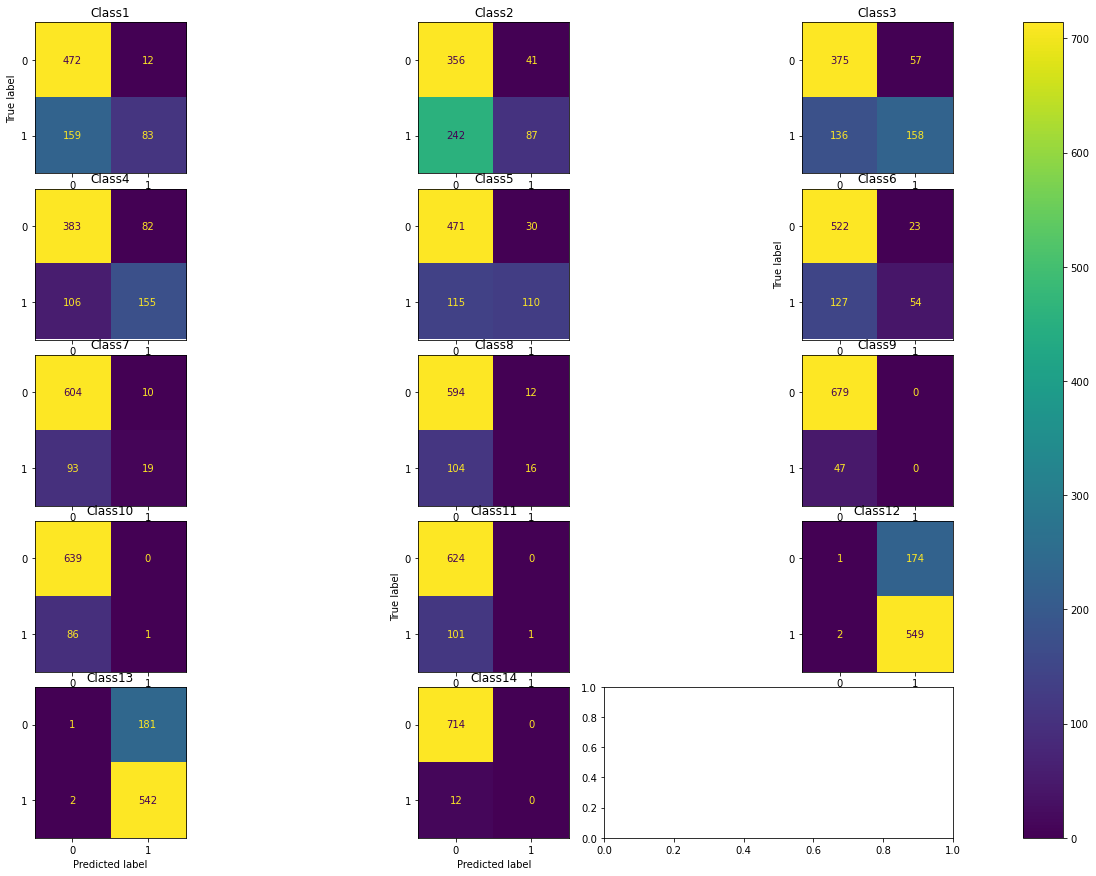

In [17]:

class_chain = ClassifierChains(base_model=RandomForestClassifier())
class_chain.fit(X_train,y_train)

y_pred_cc = class_chain.predict(X_test) # Predictions on test data
 
# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" RandomForestClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 2.2 GaussianNB

 GaussianNB Accuracy (hamming loss) of  = 51.377410 %
--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 10.606061 %
GaussianNB F1 Score of  = 53.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       242
           1       0.57      0.69      0.63       329
           2       0.60      0.70      0.65       294
           3       0.59      0.60      0.59       261
           4       0.57      0.53      0.55       225
           5       0.41      0.49      0.45       181
           6       0.30      0.58      0.39       112
           7       0.28      0.54      0.37       120
           8       0.07      0.28      0.11        47
           9       0.16      0.44      0.24        87
          10       0.17      0.42      0.24       102

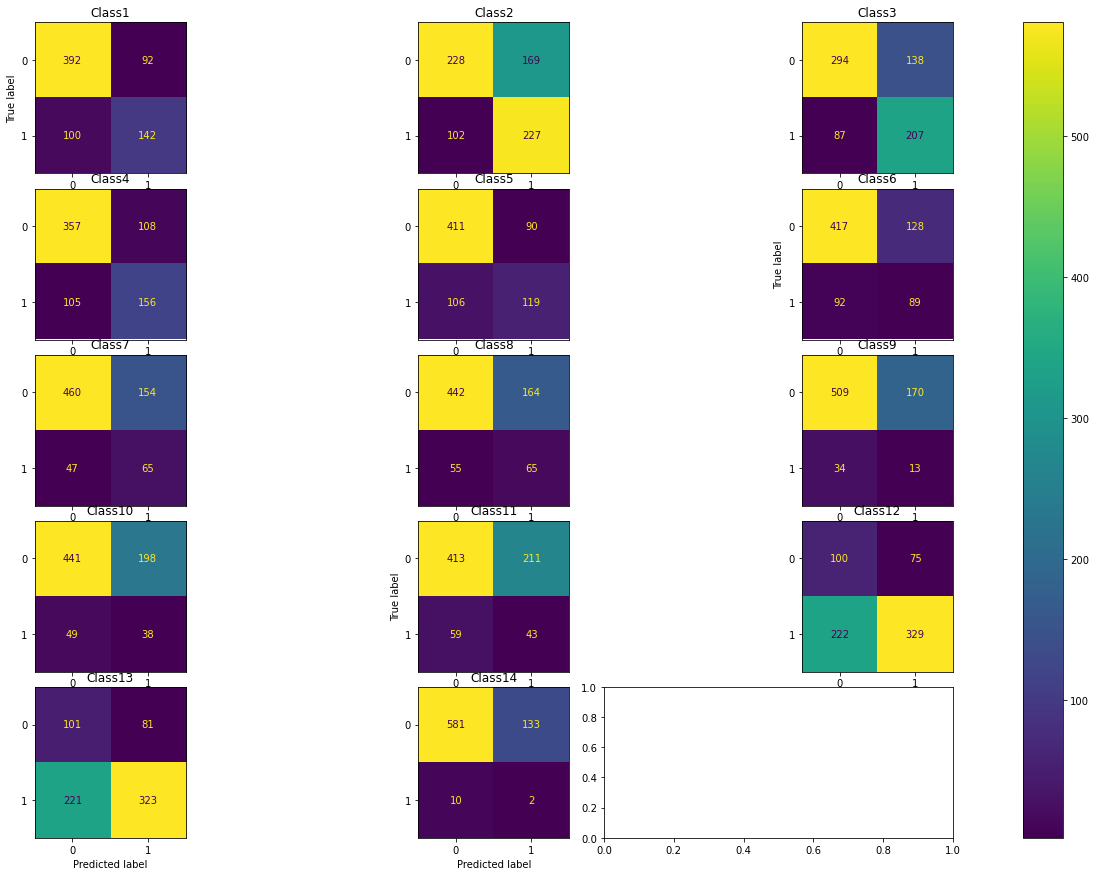

In [18]:
class_chain = ClassifierChains(base_model=GaussianNB())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" GaussianNB Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()  

# 2.3 DecisionTreeClassifier

 DecisionTreeClassifier Accuracy (hamming loss) of  = 65.426997 %
--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 11.432507 %
DecisionTreeClassifier F1 Score of  = 55.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.54      0.50      0.52       242
           1       0.55      0.47      0.51       329
           2       0.55      0.53      0.54       294
           3       0.56      0.55      0.55       261
           4       0.48      0.49      0.48       225
           5       0.33      0.35      0.34       181
           6       0.28      0.38      0.32       112
           7       0.25      0.35      0.29       120
           8       0.03      0.04      0.04        47
           9       0.15      0.11      0.13        87
          10     

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


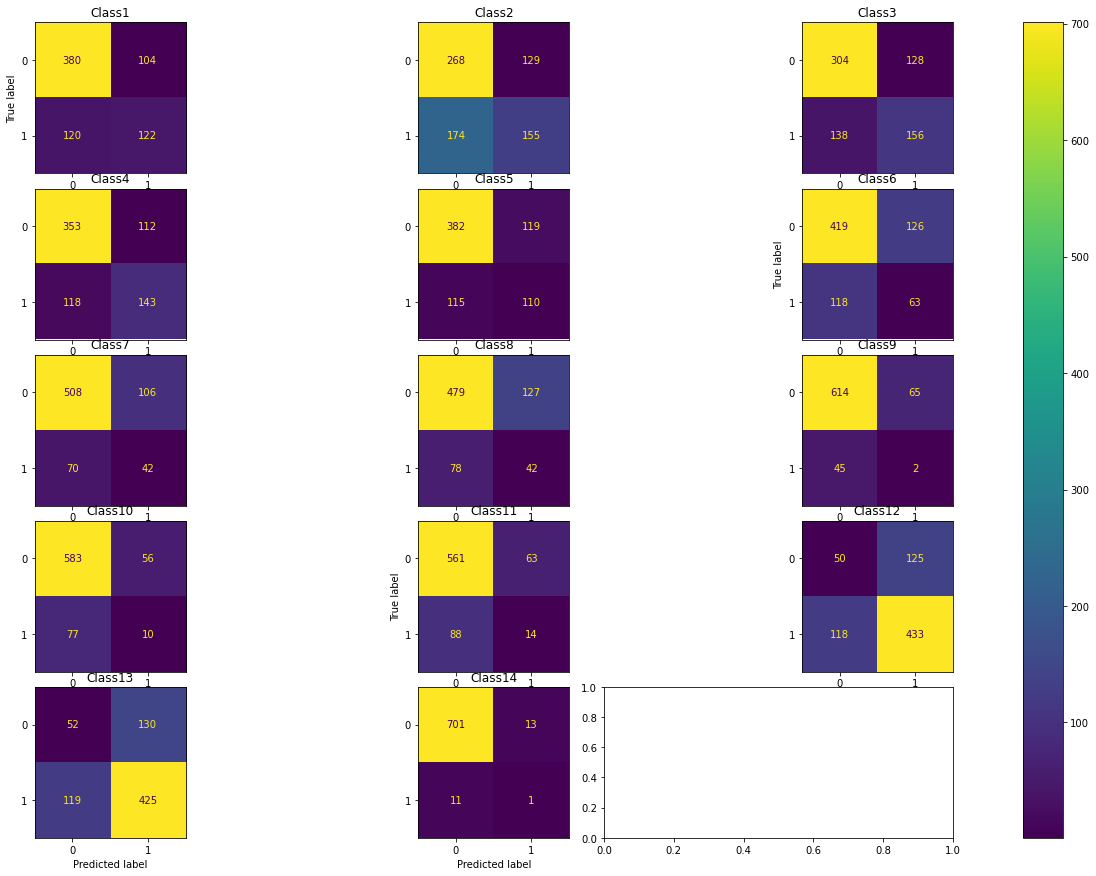

In [19]:
class_chain = ClassifierChains(base_model=DecisionTreeClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" DecisionTreeClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show() 

# 2.4 Support Vector Machine

 svm Accuracy (hamming loss) of  = 80.578512 %
--------------------------------------------------------------------------------------------------------------
svm Accuracy of  = 17.355372 %
svm F1 Score of  = 62.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.40      0.52       242
           1       0.50      0.19      0.27       329
           2       0.78      0.40      0.53       294
           3       0.68      0.56      0.61       261
           4       0.55      0.56      0.55       225
           5       0.40      0.37      0.39       181
           6       0.47      0.08      0.14       112
           7       0.53      0.08      0.14       120
           8       0.00      0.00      0.00        47
           9       0.00      0.00      0.00        87
          10       0.00      0.00      0.00       102
          11       0

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


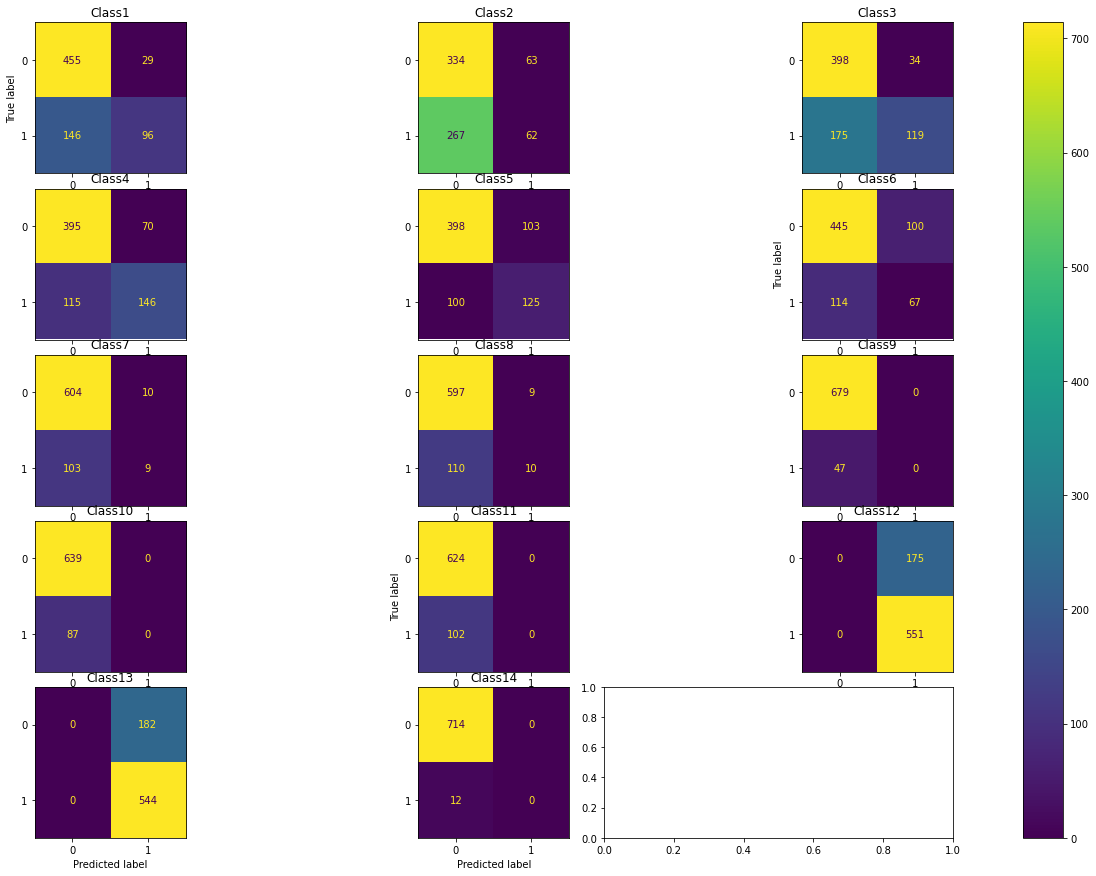

In [20]:
class_chain = ClassifierChains(base_model=svm.SVC(kernel='linear', C = 1.0))
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" svm Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("svm Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("svm F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 2.5 ExtraTreesClassifier

 ExtraTreesClassifier Accuracy (hamming loss) of  = 83.333333 %
--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 20.523416 %
ExtraTreesClassifier F1 Score of  = 63.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.32      0.47       242
           1       0.70      0.22      0.33       329
           2       0.76      0.42      0.54       294
           3       0.68      0.52      0.59       261
           4       0.68      0.60      0.64       225
           5       0.54      0.40      0.46       181
           6       0.41      0.25      0.31       112
           7       0.40      0.23      0.29       120
           8       0.00      0.00      0.00        47
           9       1.00      0.02      0.04        87
          10       1.00

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


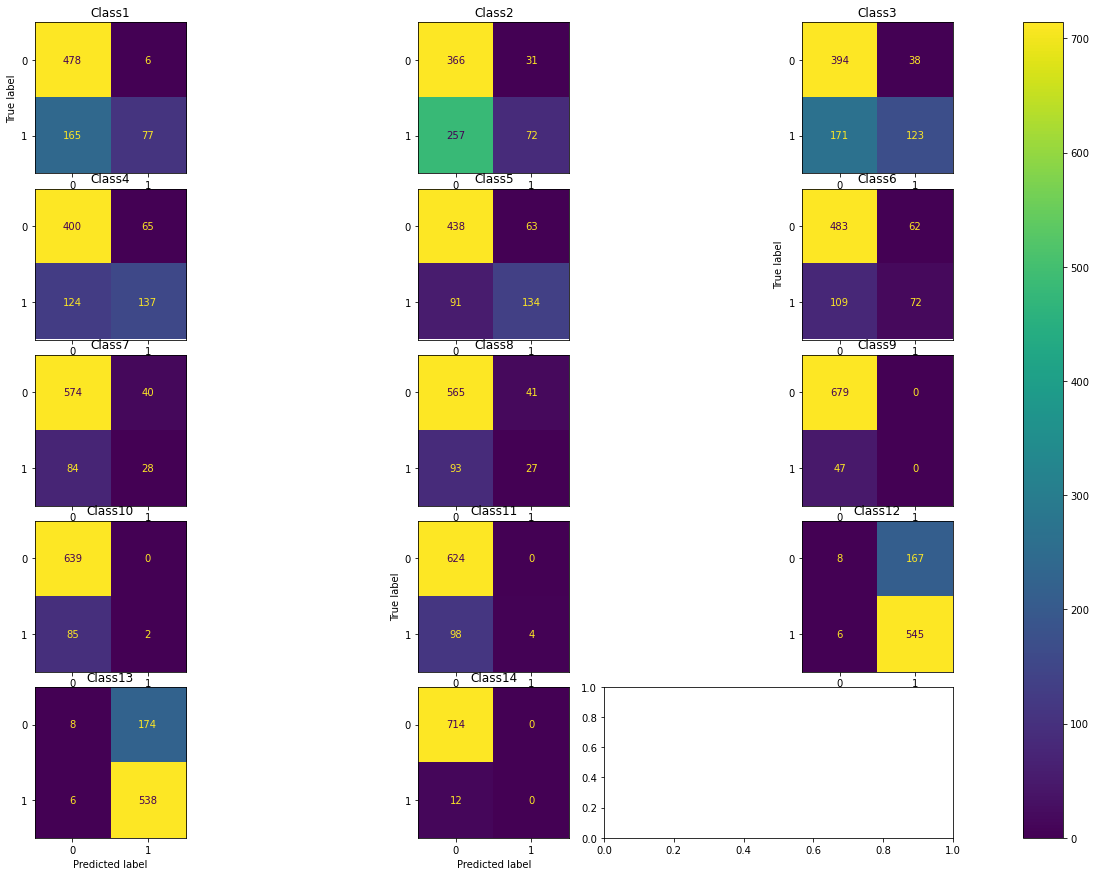

In [21]:
class_chain = ClassifierChains(base_model=ExtraTreesClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" ExtraTreesClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 2.6 AdaBoostClassifier

 AdaBoostClassifier Accuracy (hamming loss) of  = 74.517906 %
--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 17.355372 %
AdaBoostClassifier F1 Score of  = 61.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.50      0.54       242
           1       0.56      0.45      0.50       329
           2       0.65      0.61      0.63       294
           3       0.58      0.57      0.58       261
           4       0.56      0.54      0.55       225
           5       0.44      0.38      0.41       181
           6       0.36      0.27      0.31       112
           7       0.29      0.23      0.26       120
           8       0.00      0.00      0.00        47
           9       0.30      0.10      0.15        87
          10       0.26      

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


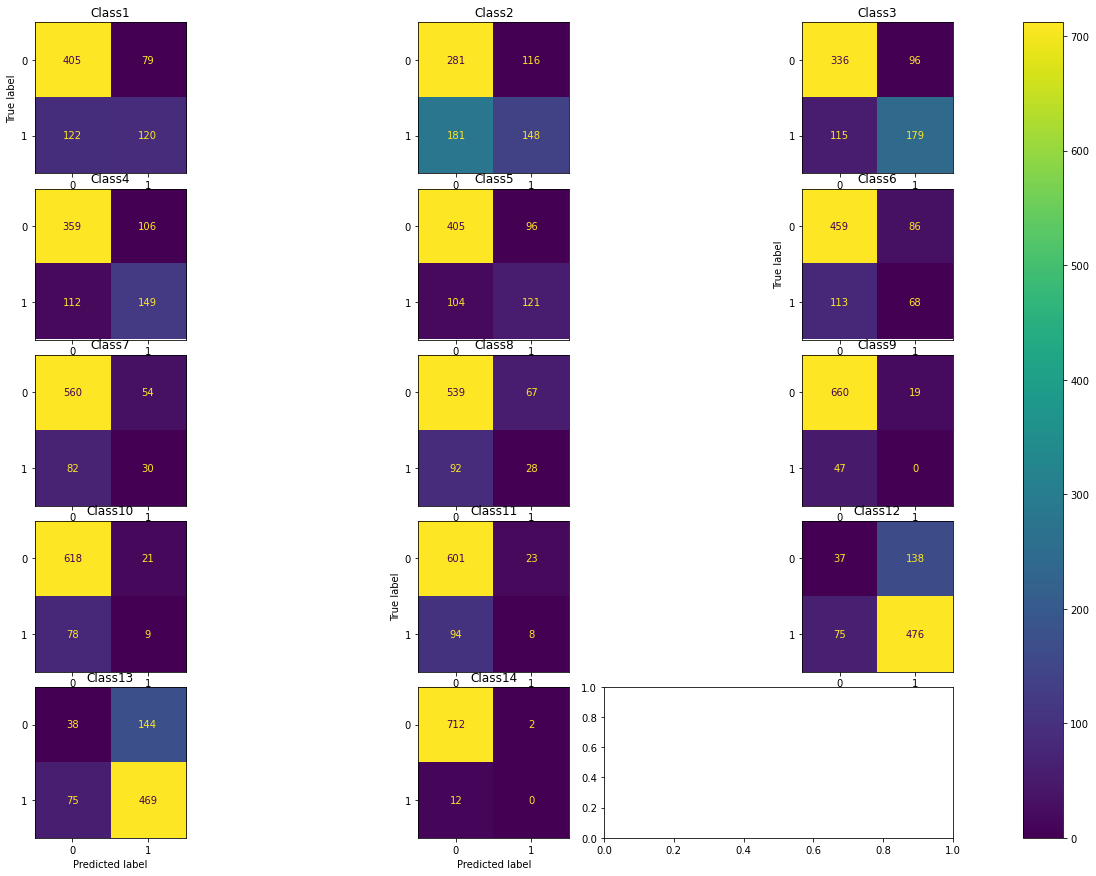

In [22]:
class_chain = ClassifierChains(base_model=AdaBoostClassifier())
class_chain.fit(X_train,y_train)
y_pred_cc = class_chain.predict(X_test) # Predictions on test data

# Matrix de confusion
acc_2 = get_accuracy_score(y_test,y_pred_cc) # Default accuracy score not used because it performs exact matching
print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_cc)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_cc, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_cc))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_cc)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_cc)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show() 

# Task 3: Implement the LabelPowerset Algorithm


# 3.1 AdaBoostClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
AdaBoostClassifier Accuracy of  = 13.085399 %
AdaBoostClassifier F1 Score of  = 56.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       242
           1       0.50      0.00      0.01       329
           2       0.43      0.98      0.60       294
           3       0.36      1.00      0.53       261
           4       0.80      0.19      0.31       225
           5       0.00      0.00      0.00       181
           6       0.00      0.00      0.00       112
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00        47
           9       0.00      0.00      0.00        87
          10       0.00      0.00      0.00       102
          11       0.76      1.00    

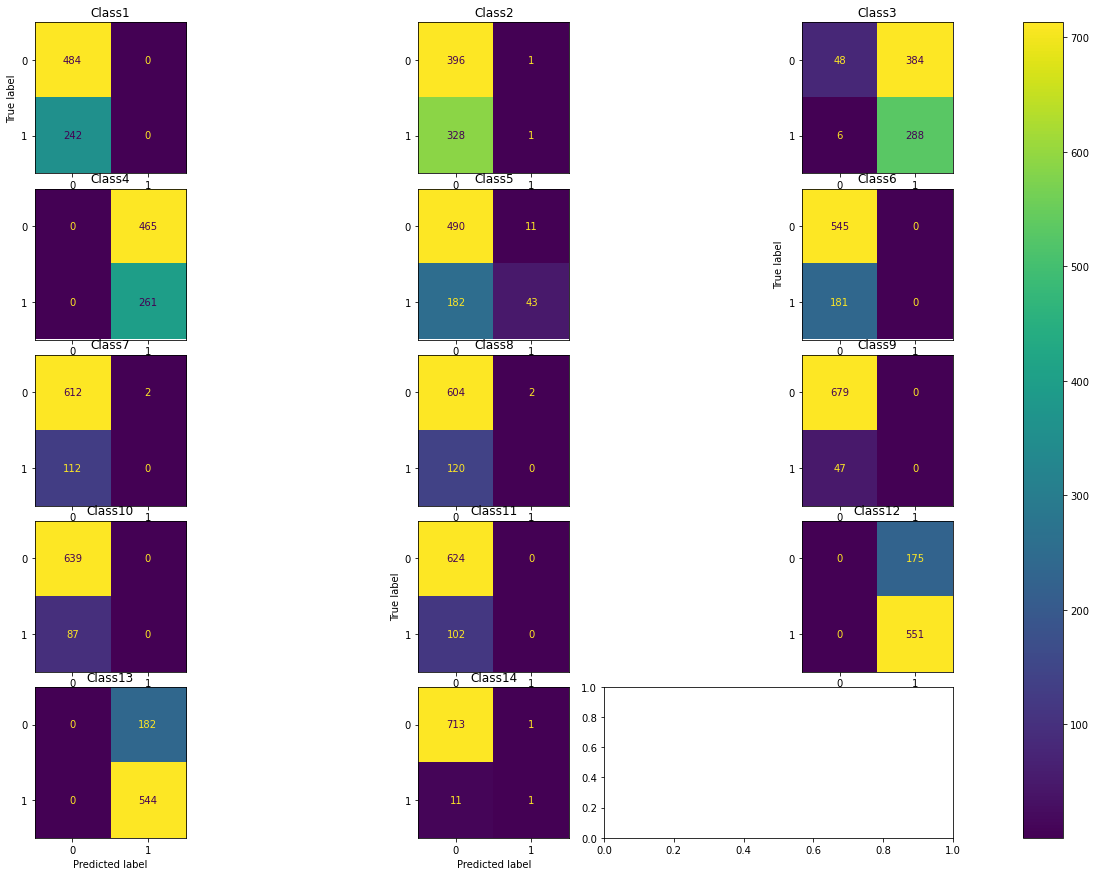

In [23]:
cla_LPowerset = LabelPowerset(AdaBoostClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
#acc_2 = get_accuracy_score(y_test,y_pred_LP) # Default accuracy score not used because it performs exact matching
#print(" AdaBoostClassifier Accuracy (hamming loss) of  = {:.6f} %".format(acc_2 * 100))
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("AdaBoostClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("AdaBoostClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.2 ExtraTreesClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
ExtraTreesClassifier Accuracy of  = 25.344353 %
ExtraTreesClassifier F1 Score of  = 66.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.48      0.56       242
           1       0.63      0.39      0.48       329
           2       0.62      0.76      0.68       294
           3       0.52      0.83      0.64       261
           4       0.71      0.56      0.63       225
           5       0.61      0.29      0.39       181
           6       0.65      0.21      0.32       112
           7       0.47      0.15      0.23       120
           8       0.00      0.00      0.00        47
           9       0.75      0.03      0.07        87
          10       0.83      0.05      0.09       102
          11       0.78      0.95

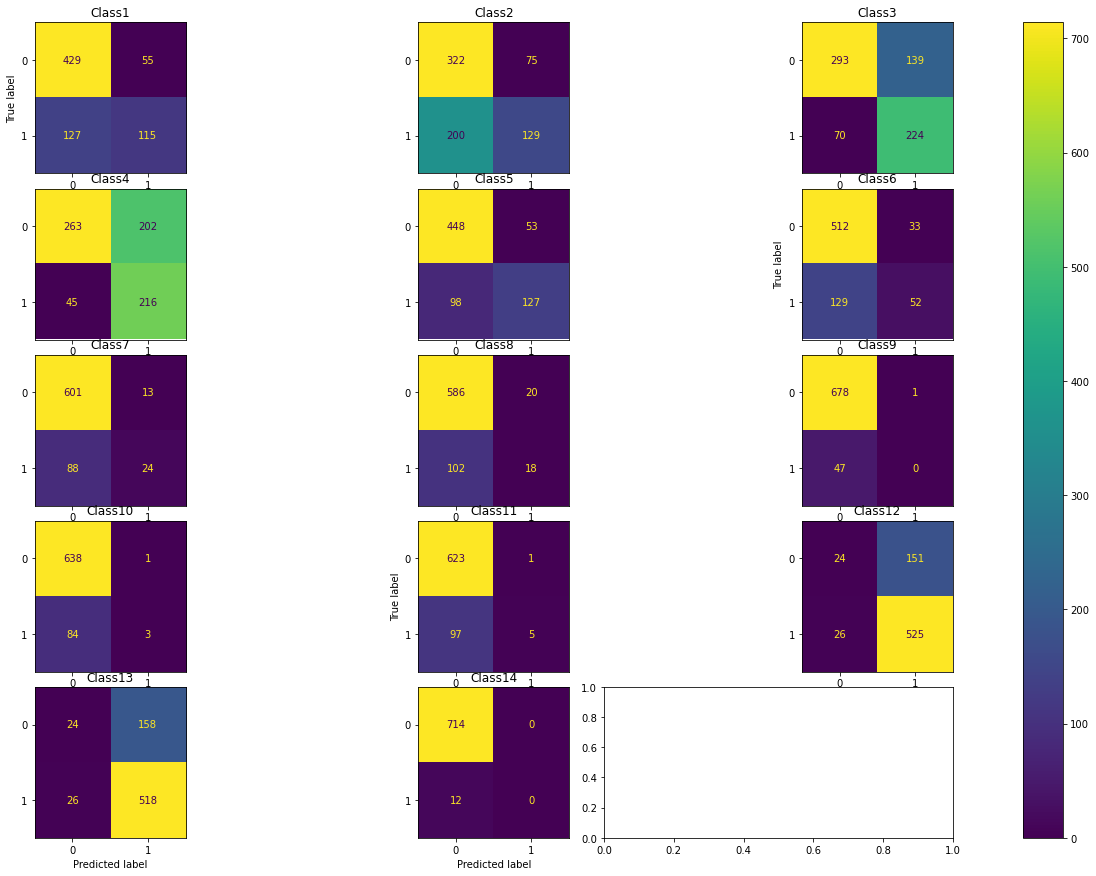

In [24]:

cla_LPowerset = LabelPowerset(ExtraTreesClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("ExtraTreesClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("ExtraTreesClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.3 Support Vector Machine

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
Support Vector Machine Accuracy of  = 24.793388 %
Support Vector Machine F1 Score of  = 65.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.51      0.58       242
           1       0.59      0.43      0.50       329
           2       0.61      0.77      0.68       294
           3       0.54      0.81      0.65       261
           4       0.65      0.44      0.52       225
           5       0.56      0.22      0.31       181
           6       0.54      0.18      0.27       112
           7       0.46      0.14      0.22       120
           8       0.00      0.00      0.00        47
           9       1.00      0.01      0.02        87
          10       1.00      0.01      0.02       102
          11       0.78      

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


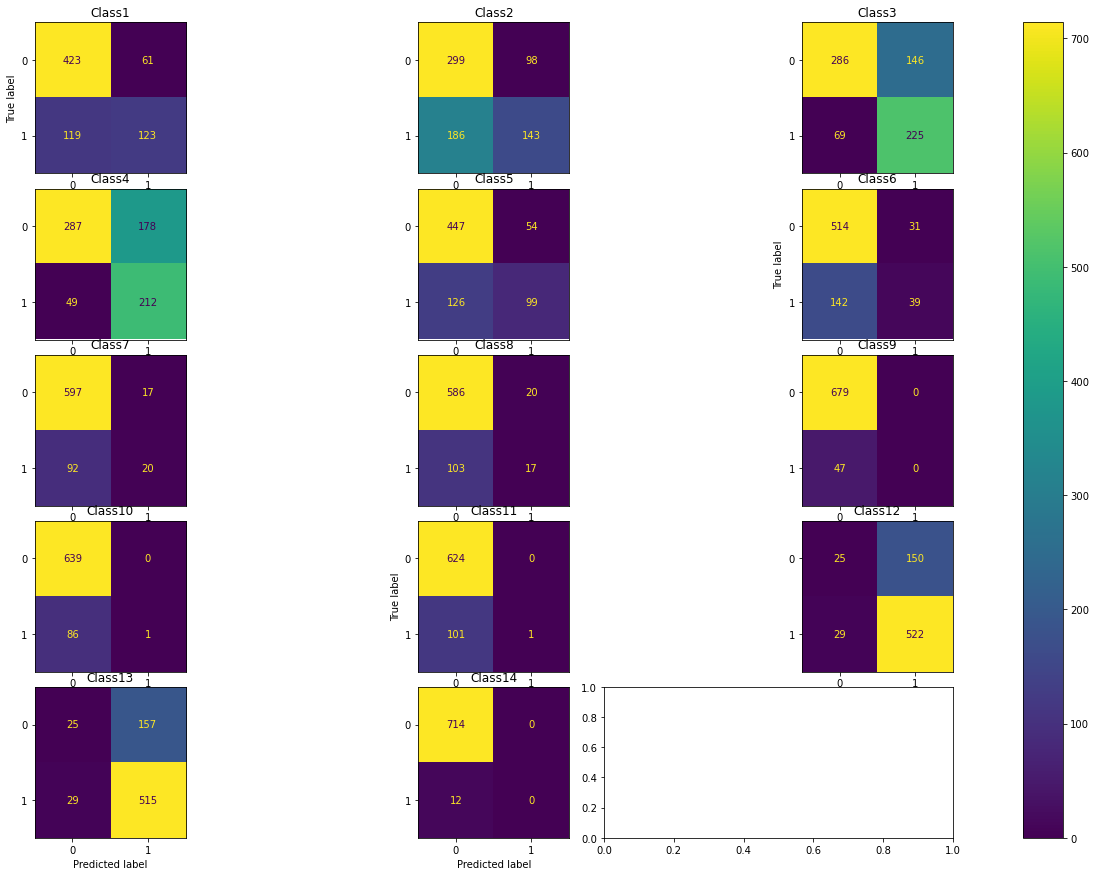

In [25]:

cla_LPowerset = LabelPowerset(svm.SVC(kernel='linear', C = 1.0))
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("Support Vector Machine Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("Support Vector Machine F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.4 DecisionTreeClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier Accuracy of  = 14.462810 %
DecisionTreeClassifier F1 Score of  = 54.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.43      0.45       242
           1       0.53      0.46      0.49       329
           2       0.55      0.54      0.55       294
           3       0.51      0.53      0.52       261
           4       0.51      0.50      0.51       225
           5       0.37      0.36      0.36       181
           6       0.26      0.30      0.28       112
           7       0.27      0.35      0.30       120
           8       0.13      0.15      0.14        47
           9       0.18      0.14      0.16        87
          10       0.23      0.16      0.18       102
          11       0.78      

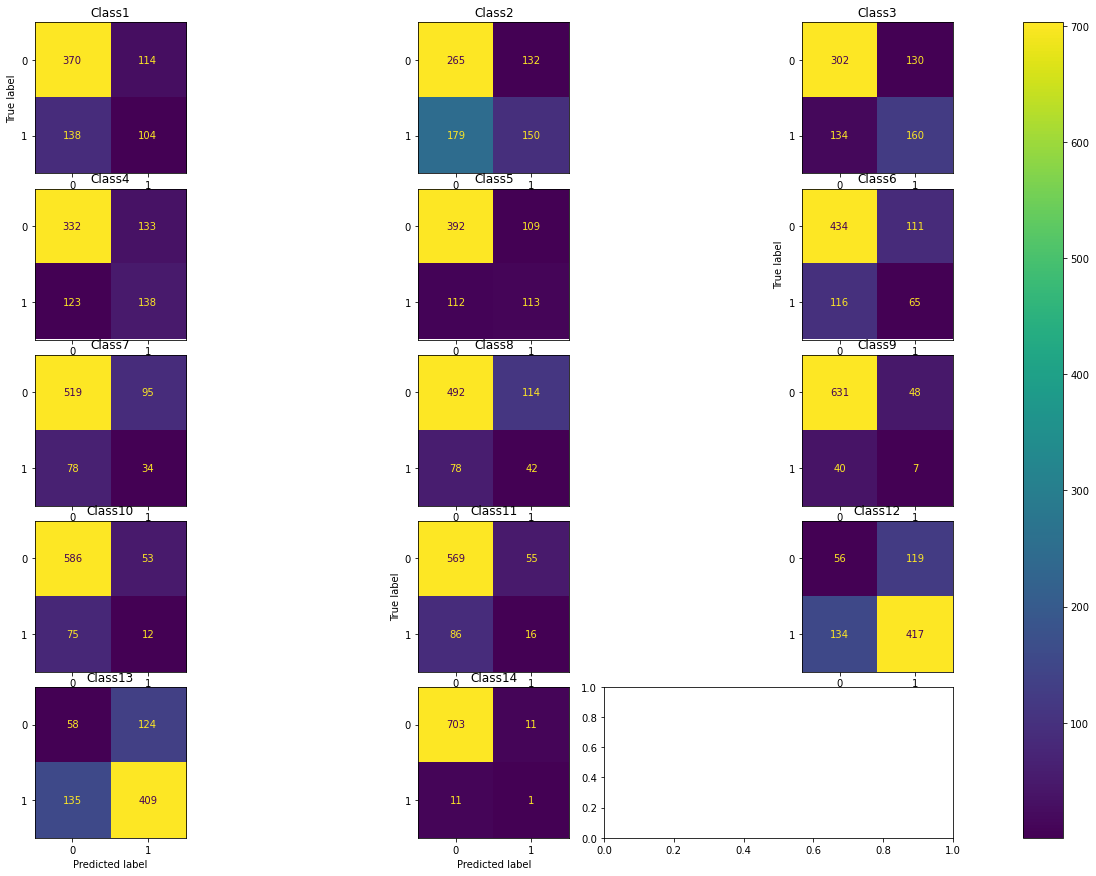

In [26]:

cla_LPowerset = LabelPowerset(DecisionTreeClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("DecisionTreeClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("DecisionTreeClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.5 GaussianNB

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
GaussianNB Accuracy of  = 19.146006 %
GaussianNB F1 Score of  = 61.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.55      0.58       242
           1       0.65      0.62      0.63       329
           2       0.63      0.56      0.59       294
           3       0.61      0.51      0.55       261
           4       0.56      0.56      0.56       225
           5       0.43      0.44      0.44       181
           6       0.33      0.40      0.36       112
           7       0.29      0.40      0.34       120
           8       0.07      0.06      0.07        47
           9       0.30      0.14      0.19        87
          10       0.34      0.17      0.22       102
          11       0.80      0.80      0.80       551

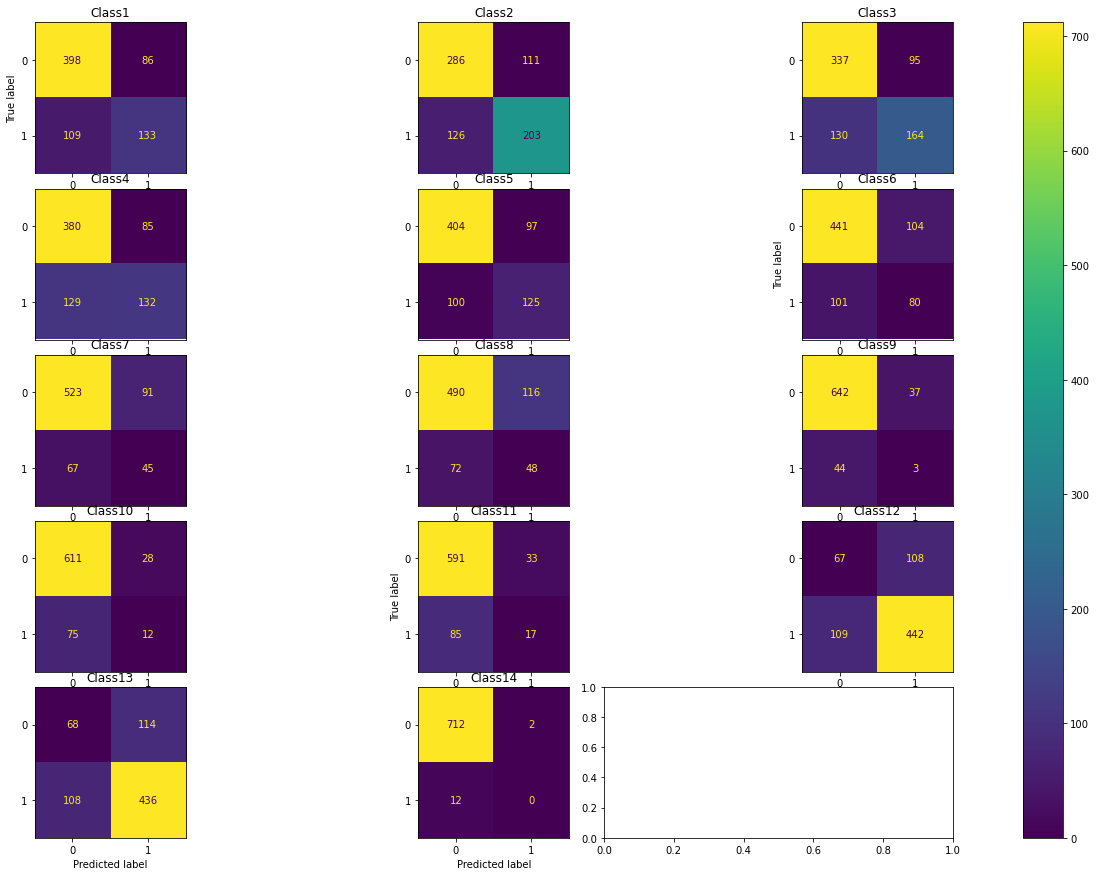

In [27]:

cla_LPowerset = LabelPowerset(GaussianNB())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("GaussianNB Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("GaussianNB F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

# 3.6 RandomForestClassifier

C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Abdelkader\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------------------------------------------------------------------
RandomForestClassifier Accuracy of  = 26.584022 %
RandomForestClassifier F1 Score of  = 66.000000 %
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.55      0.61       242
           1       0.62      0.44      0.52       329
           2       0.62      0.74      0.68       294
           3       0.54      0.83      0.65       261
           4       0.71      0.54      0.61       225
           5       0.64      0.26      0.37       181
           6       0.62      0.19      0.29       112
           7       0.53      0.15      0.23       120
           8       0.00      0.00      0.00        47
           9       0.60      0.03      0.07        87
          10       0.71      0.05      0.09       102
          11       0.77      

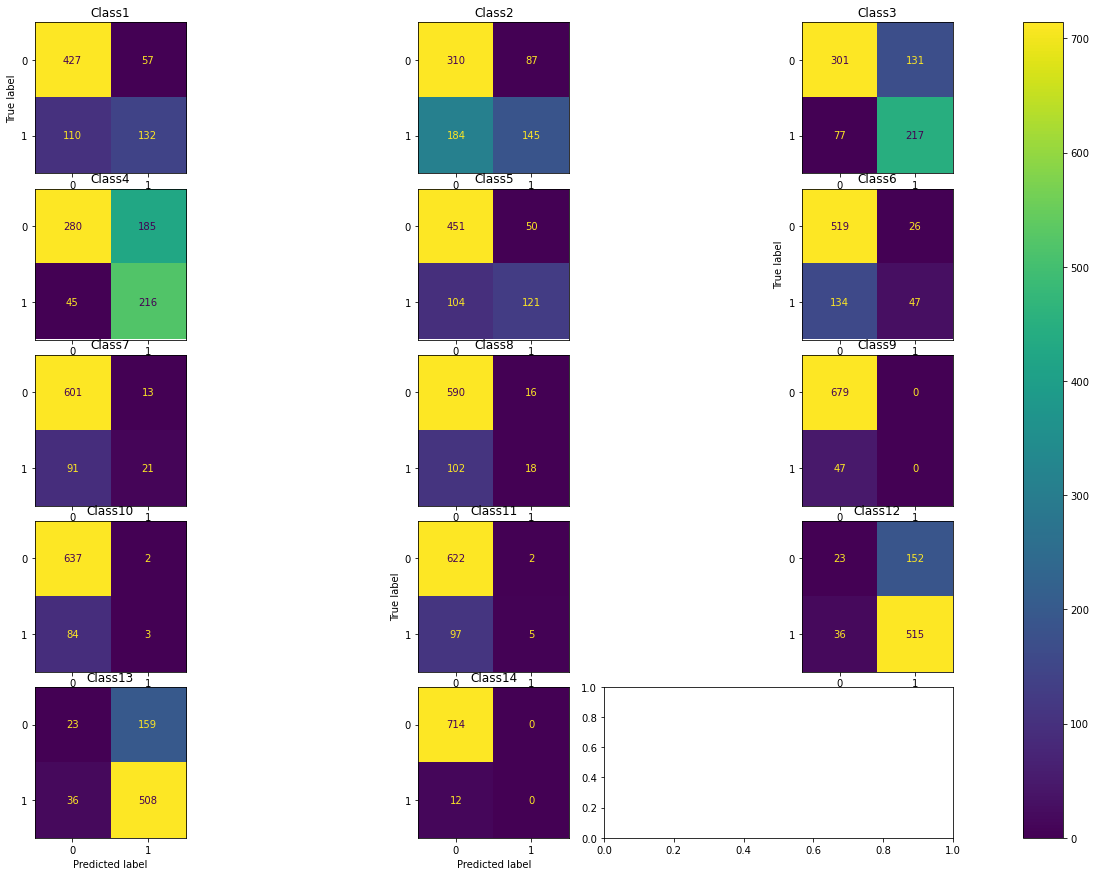

In [28]:

cla_LPowerset = LabelPowerset(RandomForestClassifier())
cla_LPowerset.fit(X_train,y_train)
y_pred_LP = cla_LPowerset.predict(X_test) # Predictions on test data

# Matrix de confusion
print('--------------------------------------------------------------------------------------------------------------')   
acc = accuracy_score(y_test,y_pred_LP)
print("RandomForestClassifier Accuracy of  = {:.6f} %".format(acc * 100))
f1 = round(f1_score(y_test,y_pred_LP, average = 'micro'),2)  
print("RandomForestClassifier F1 Score of  = {:.6f} %".format(f1 * 100))
print('--------------------------------------------------------------------------------------------------------------')   

print(classification_report(y_test,y_pred_LP))    
print('--------------------------------------------------------------------------------------------------------------')   

multilabel_confusion_matrix(y_test, y_pred_LP)
cm = metrics.multilabel_confusion_matrix(y_test, y_pred_LP)
#print(f'Confusion Matrix:\n{cm}')
#print(f'Confusion Matrix:\n{cm[1]}')

f, axes = plt.subplots(5, 3, figsize=(25, 15))
axes = axes.ravel()
for i in range(14):
    disp = ConfusionMatrixDisplay(cm[i])
    disp.plot(ax=axes[i], values_format='.4g')
    #disp.ax_.set_title(f'Label',labels[i])
    disp.ax_.set_title(labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()